In [4]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
import math
import matplotlib.pyplot as plt

In [5]:
#Removed first LIDAR data which is considered in next cell
measurements= pd.read_csv('data_ekf.txt',header=None, delim_whitespace = True, skiprows=1) 
measurements

,0,1,2,3,4,5,6,7,8,9,10
0,R,1.014892,0.554329,4.892807e+00,1.477010e+15,0.859997,0.600045,5.199747,1.796856e-03,3.455661e-04,1.382155e-02
1,L,1.173848,0.481073,1.477010e+15,1.119984e+00,0.600225,5.199429,0.005390,1.036644e-03,2.072960e-02,NaN
2,R,1.047505,0.389240,4.511325e+00,1.477010e+15,1.379955,0.600629,5.198979,1.077814e-02,2.073124e-03,2.763437e-02
3,L,1.650626,0.624690,1.477010e+15,1.639904e+00,0.601347,5.198392,0.017960,3.454842e-03,3.453479e-02,NaN
4,R,1.698300,0.298280,5.209986e+00,1.477010e+15,1.899823,0.602470,5.197661,2.693234e-02,5.181582e-03,4.142974e-02
...,...,...,...,...,...,...,...,...,...,...,...
494,R,13.645960,2.189595,-2.987211e+00,1.477010e+15,-8.019735,10.905010,5.198959,1.796166e-02,3.454842e-03,-2.763437e-02
495,L,-7.519712,11.000450,1.477010e+15,-7.759787e+00,10.905730,5.199421,0.010779,2.073124e-03,-2.072960e-02,NaN
496,R,12.885600,2.169303,-2.779369e+00,1.477010e+15,-7.499815,10.906130,5.199745,5.390285e-03,1.036644e-03,-1.382155e-02
497,L,-7.156314,10.815040,1.477010e+15,-7.239828e+00,10.906310,5.199937,0.001797,3.455661e-04,-6.911322e-03,NaN


In [6]:
#initial readings of LIDAR
prv_time = 1477010443000000/1000000.0
global x
x = np.array([
        [0.312242], 
        [0.5803398],
        [0],
        [0],
        [0],
        [0]
        ]) 
ground_truth = np.zeros([6, 1])

In [7]:

P = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 100, 0, 0, 0],
        [0, 0, 0, 100, 0, 0],
        [0, 0, 0, 0, 100, 0],
        [0, 0, 0, 0, 0, 100]])
F = np.array([
        [1.0, 0, 1.0, 0, 0, 0],
        [0, 1.0, 0, 1.0, 0, 0],
        [0, 0, 1.0, 0, 0, 0],
        [0, 0, 0, 1.0, 0, 0],
        [0, 0, 0, 0, 1.0, 1.0],
        [0, 0, 0, 0, 0, 1.0]])

noise_ax = 9
noise_ay = 9
noise_alpha = 9

Q = np.zeros([6, 6])


In [8]:
def H_jacobian(x): 
  x_t = x[0][0]
  y_t = x[1][0]
  xdot = x[2][0]
  ydot = x[3][0]

  H_jacobian_radar = np.array([[x_t/pow((x_t**2+y_t**2), 1/2), y_t/pow((x_t**2+y_t**2),1/2), 0, 0, 0, 0],
                             [(y_t*(xdot*y_t-ydot*x_t)/pow((x_t**2+y_t**2),3/2)), (x_t*(ydot*x_t-xdot*y_t)/pow((x_t**2+y_t**2),3/2)), x_t/pow((x_t**2+y_t**2),1/2), y_t/pow((x_t**2+y_t**2),1/2), 0, 0],
                             [0, 0, 0, 0, 1, 0],
                             [0, 0, 0, 0, 0, 1]])
  return  H_jacobian_radar
 
z_radar = np.zeros([4, 1])
R_radar = np.array([
        [0.09, 0, 0,0],
        [0, 0.09, 0,0],
        [0, 0, 0.09,0],
        [0, 0, 0,0.09]
        ])

In [9]:
H_lidar = np.array([
        [1.0, 0, 0, 0, 0, 0],
        [0, 1.0, 0, 0, 0, 0]
        ])
I = np.identity(6)
z_lidar = np.zeros([2, 1])
R_lidar = np.array([
        [0.0225, 0],
        [0, 0.0225]
        ])

In [10]:
def EKF_predict():
  # Predict Step
  global x, P, Q
  x = np.matmul(F, x)
  Ft = np.transpose(F)
  P = np.add(np.matmul(F, np.matmul(P, Ft)), Q)

In [11]:
PI = math.pi

w_radar = np.array([
        [0.5], 
        [0.5],
        [0.01],
        [0.01]])

w_lidar = np.array([
        [0.05], 
        [0.05]])

def EKF_update(z, sensor):
  global x, P  
  
  if sensor == 'R':
    H = H_jacobian(x)
    zpred = np.add(np.matmul(H, x),w_radar)
  else:
    H = H_lidar
    zpred = np.add(np.matmul(H, x),w_lidar)
  # Measurement update step
  
  Y = np.subtract(z, zpred )

  if sensor == 'R':
    while(Y[2][0] > PI):
      Y[2][0] = Y[2][0] -2*PI
    while(Y[2][0] < -PI):
      Y[2][0] = Y[2][0] + 2*PI
  

  Ht = np.transpose(H)
  S = np.add(np.matmul(H, np.matmul(P, Ht)), R)
  PHt = np.matmul(P, Ht)
  Si = inv(S)
  K = np.matmul(PHt, Si)
  
  # New state
  x = np.add(x, np.matmul(K, Y))

  P = np.matmul(np.subtract(I ,np.matmul(K, H)), P)


In [12]:
print(PI)

3.141592653589793


In [13]:

Estimate= []
GT= []
x_Estimate = []
y_Estimate = []
x_groundtruth = []
y_groundtruth = []
phi_Estimate = []
w_Estimate = []
phi_GT = []
w_GT = []
lidar_x = []
lidar_y = []
radar_x = []
radar_y = []
q=0
k=0
for i in range (len(measurements)):
    new_measurement = measurements.iloc[i, :].values
    

    
    if new_measurement[0] == 'L':
      #Calculate Timestamp and its power variables
      cur_time = new_measurement[3]/1000000.0
    if new_measurement[0] == 'R':
      cur_time = new_measurement[4]/1000000.0

    dt = cur_time - prv_time
    prv_time = cur_time

    dt_2 = dt * dt
    dt_3 = dt_2 * dt
    dt_4 = dt_3 * dt

    #Updating matrix F with dt value
    F[0][2] = dt
    F[1][3] = dt
    F[4][5] = dt

    #Updating Q matrix
    Q[0][0] = dt_4/4*noise_ax
    Q[0][2] = dt_3/2*noise_ax
    Q[1][1] = dt_4/4*noise_ay
    Q[1][3] = dt_3/2*noise_ay
    Q[2][0] = dt_3/2*noise_ax
    Q[2][2] = dt_2*noise_ax
    Q[3][1] = dt_3/2*noise_ay
    Q[3][3] = dt_2*noise_ay
    Q[4][4] = dt_4/4*noise_alpha
    Q[4][5] = dt_3/2*noise_alpha
    Q[5][4] = dt_3/2*noise_alpha
    Q[5][5] = dt_2*noise_alpha

    #Q = np.eye(6,6)*0.1
    if new_measurement[0] == 'L':
      #Updating sensor readings
      z_lidar[0][0] = new_measurement[1]
      z_lidar[1][0] = new_measurement[2]
      lidar_x.insert(k, z_lidar[0][0])
      lidar_y.insert(k,z_lidar[1][0])
      k +=1

      #Collecting ground truths
      ground_truth[0] = new_measurement[4]
      ground_truth[1] = new_measurement[5]
      ground_truth[2] = new_measurement[6]
      ground_truth[3] = new_measurement[7]
      ground_truth[4] = new_measurement[8]
      ground_truth[5] = new_measurement[9]

      R = R_lidar

      EKF_predict()
      EKF_update(z_lidar, new_measurement[0])

      x_Estimate.insert(i, x[0][0])
      y_Estimate.insert(i, x[1][0])
      x_groundtruth.insert(i, ground_truth[0][0])
      y_groundtruth.insert(i, ground_truth[1][0])
      phi_Estimate.insert(i, x[4][0])
      w_Estimate.insert(i, x[5][0])
      phi_GT.insert(i,ground_truth[4][0] )
      w_GT.insert(i,ground_truth[5][0])
      Estimate.insert(i, [x[0][0], x[1][0], x[2][0], x[3][0], x[4][0], x[5][0]])
      #Estimate = np.append(Estimate,  , axis = 0)
      GT.insert(i,[ground_truth[0][0], ground_truth[1][0], ground_truth[2][0], ground_truth[3][0], ground_truth[4][0], ground_truth[5][0]])
      print("--------------------------------------------------------------------------------")
      print('{:15s} | {:8.3f} | {:8.3f} |'.format("LIDAR:", z_lidar[0][0], z_lidar[1][0])) 
      print('{:10s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("Lidar Estimate:", x[0][0], x[1][0], x[2][0], x[3][0], x[4][0], x[5][0] ))
      print('{:10s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("Ground Truth  :", ground_truth[0][0], ground_truth[1][0], ground_truth[2][0], ground_truth[3][0], ground_truth[4][0], ground_truth[5][0]))
      #print('Lidar Estimated X: ', x)
      #print('Lidar Ground Truth X', ground_truth)

    if new_measurement[0] == 'R':

      if i%2 == 0 and i!=0:
        prev_meaurement = measurements.iloc[(i-2), :].values
      elif i==0:
        prev_measurement = measurements.iloc[i, :].values
      #print(prev_measurement)
      
      #Updating sensor readings
      z_radar[0][0] = new_measurement[1]#r
      z_radar[1][0] = new_measurement[3]#rdot
      z_radar[2][0] = new_measurement[2]#phi
      r_x = z_radar[0][0]*math.cos(z_radar[2][0])
      r_y = z_radar[0][0]*math.sin(z_radar[2][0])
      radar_x.insert(q,r_x)
      radar_y.insert(q,r_y)
      q +=1
      del_t = (new_measurement[4] - prev_measurement[4])/1000000.0
      if del_t:
        z_radar[3][0] = (new_measurement[2] - prev_measurement[2])/del_t 
      else:
        z_radar[3][0] = 0
        
      #print(z_radar[3][0])

      #Collecting ground truths
      ground_truth[0] = new_measurement[5]
      ground_truth[1] = new_measurement[6]
      ground_truth[2] = new_measurement[7]
      ground_truth[3] = new_measurement[8]
      ground_truth[4] = new_measurement[9]
      ground_truth[5] = new_measurement[10]

      R = R_radar
      #x_prev = x
      #print(x_prev)
      EKF_predict()
      EKF_update(z_radar, new_measurement[0])
      #x_current = x
      #print(x_current)
      x_Estimate.insert(i, x[0][0])
      y_Estimate.insert(i, x[1][0])
      x_groundtruth.insert(i, ground_truth[0][0])
      y_groundtruth.insert(i, ground_truth[1][0])
      phi_Estimate.insert(i, x[4][0])
      w_Estimate.insert(i, x[5][0])
      phi_GT.insert(i,ground_truth[4][0] )
      w_GT.insert(i,ground_truth[5][0])

      GT.insert(i,[ground_truth[0][0], ground_truth[1][0], ground_truth[2][0], ground_truth[3][0], ground_truth[4][0], ground_truth[5][0]] )
      
      print("--------------------------------------------------------------------------------")
      print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} |{:8.3f} |'.format("RADAR:", z_radar[0][0], z_radar[1][0], z_radar[2][0], z_radar[3][0])) 
      print('{:10s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("Radar Estimate:", x[0][0], x[1][0], x[2][0], x[3][0], x[4][0], x[5][0] ))
      print('{:10s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("Ground Truth  :", ground_truth[0][0], ground_truth[1][0], ground_truth[2][0], ground_truth[3][0], ground_truth[4][0], ground_truth[5][0]))
      print('')
      #print('Radar Estimated X: ', x)
      #print('Radar Ground Truth', ground_truth)

    

--------------------------------------------------------------------------------
RADAR:          |    1.015 |    4.893 |    0.554 |   0.000 |
Radar Estimate: |    0.258 |    0.480 |    2.079 |    3.864 |    0.544 |   -0.010 |
Ground Truth  : |    0.860 |    0.600 |    5.200 |    0.002 |    0.000 |    0.014 |

--------------------------------------------------------------------------------
LIDAR:          |    1.174 |    0.481 |
Lidar Estimate: |    1.101 |    0.407 |    5.503 |    2.030 |    0.543 |   -0.010 |
Ground Truth  : |    1.120 |    0.600 |    5.199 |    0.005 |    0.001 |    0.021 |
--------------------------------------------------------------------------------
RADAR:          |    1.048 |    4.511 |    0.389 |  -1.651 |
Radar Estimate: |    1.103 |    0.543 |    3.004 |    3.363 |    0.420 |   -1.002 |
Ground Truth  : |    1.380 |    0.601 |    5.199 |    0.011 |    0.002 |    0.028 |

--------------------------------------------------------------------------------
LIDAR:  

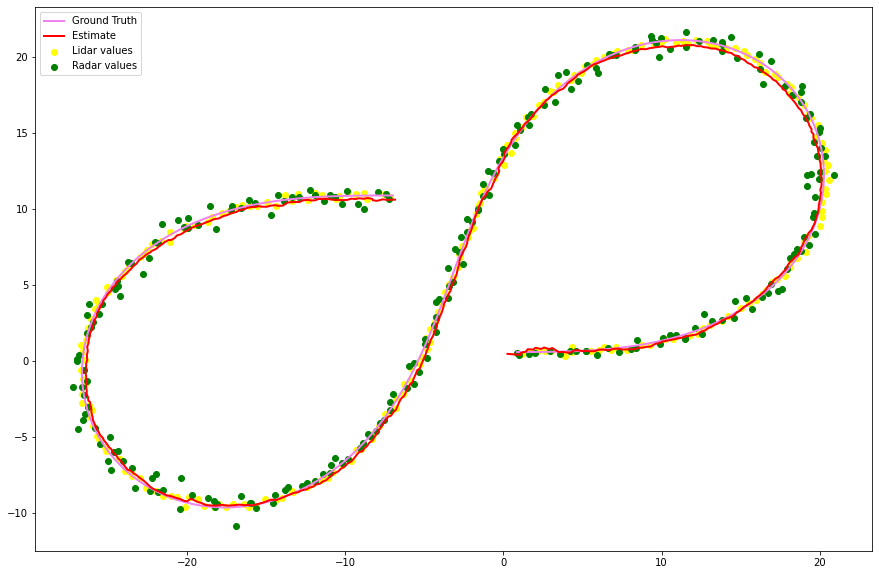

In [14]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(x_groundtruth, y_groundtruth, color = 'violet', linewidth=2, label = 'Ground Truth')
plt.scatter(lidar_x,lidar_y, color = 'yellow', label = 'Lidar values')
plt.scatter(radar_x, radar_y, color = 'green', label = 'Radar values')
plt.plot(x_Estimate, y_Estimate,color = 'red', linewidth=2, label = 'Estimate')
plt.legend()
plt.show()
